In [1]:
import os

In [2]:
DATA_DIR = os.path.abspath('./data')
IMDB_DIR = os.path.join(DATA_DIR, 'imdb5k')
IMDB_URL = r"https://github.com/ben0it8/transformer-finetuning/raw/master/imdb5k.tar.gz"

#### Dataset downloading

In [3]:
import requests
import tarfile
from tqdm import tqdm

def download_url(url:str, dest:str, overwrite:bool=True, show_progress=True, 
                 chunk_size=1024*1024, timeout=4, retries=5)->None:
    "Download `url` to `dest` unless it exists and not `overwrite`."
    dest = os.path.join(dest, os.path.basename(url))
    if os.path.exists(dest) and not overwrite: 
        print(f"File {dest} already exists!")
        return dest

    s = requests.Session()
    s.mount('http://',requests.adapters.HTTPAdapter(max_retries=retries))
    u = s.get(url, stream=True, timeout=timeout)
    try: file_size = int(u.headers["Content-Length"])
    except: show_progress = False
    print(f"Downloading {url}")
    with open(dest, 'wb') as f:
        nbytes = 0
        if show_progress: 
            pbar = tqdm(range(file_size), leave=False)
        try:
            for chunk in u.iter_content(chunk_size=chunk_size):
                nbytes += len(chunk)
                if show_progress: pbar.update(nbytes)
                f.write(chunk)
        except requests.exceptions.ConnectionError as e:
            print(f"Download failed after {retries} retries.")
            import sys;sys.exit(1)
        finally:
            return dest
        
def untar(file_path, dest:str):
    "Untar `file_path` to `dest`"
    print(f"Untar {os.path.basename(file_path)} to {dest}")
    with tarfile.open(file_path) as tf:
        tf.extractall(path=str(dest))

file_path = download_url(IMDB_URL, 'data', overwrite=True)
untar(file_path, DATA_DIR)

Untar imdb5k.tar.gz to c:\Users\Manuel\Projects\GitHub_Repositories\ds-practice\ml\general\transformer\sentiment-analysis\data


#### Dataset inspection

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df_train = pd.read_csv(filepath_or_buffer='./data/imdb5k/imdb5k_train.csv')
df_train.head()

,label,text
0,neg,"Bah. Another tired, desultory reworking of an ..."
1,neg,Twist endings can be really cool in a movie. I...
2,pos,Every time I watch this movie I am more impres...
3,pos,I absolutely LOVED this film! I do not at all ...
4,pos,"Though the plot elements to ""The Eighth Day"" s..."


pos    2544
neg    2456
Name: label, dtype: int64


<AxesSubplot:>

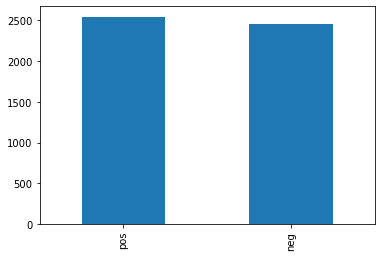

In [6]:
print(df_train['label'].value_counts())
df_train['label'].value_counts().plot.bar()

In [7]:
df_test = pd.read_csv(filepath_or_buffer='./data/imdb5k/imdb5k_test.csv')
df_test.head()

,label,text
0,pos,"OK, so the Oscars seem to get hyped just a lit..."
1,neg,"To compare this squalor with an old, low budge..."
2,neg,I've seen some bad things in my time. A half d...
3,neg,What a HUGE pile of dung. Shot-on-video (REALL...
4,neg,If you like occasional nudity with junior high...


neg    2541
pos    2459
Name: label, dtype: int64


<AxesSubplot:>

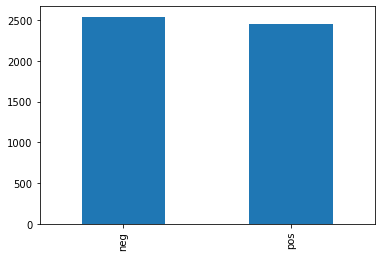

In [8]:
print(df_test['label'].value_counts())
df_test['label'].value_counts().plot.bar()

#### Data processing

In [9]:
import torch
import torch.nn as nn
import numpy as np
from pytorch_transformers import BertTokenizer

In [10]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_function(x):
    return tokenizer(x, padding='max_length', truncation=True)

In [11]:
df_train.head()

,label,text
0,neg,"Bah. Another tired, desultory reworking of an ..."
1,neg,Twist endings can be really cool in a movie. I...
2,pos,Every time I watch this movie I am more impres...
3,pos,I absolutely LOVED this film! I do not at all ...
4,pos,"Though the plot elements to ""The Eighth Day"" s..."


In [12]:
df_train['text_tokenized'] = df_train['text'].apply(func=lambda x: tokenize_function(x)['input_ids'])
df_train.head()

In [ ]:
from torch.utils.data import DataLoader
dataloader_train = DataLoader(dataset=df_train, batch_size=4, shuffle=True)
dataloader_test = DataLoader(dataset=df_test, batch_size=4, shuffle=True)

#### Model setup

In [ ]:
from transformers import BertForSequenceClassification, AdamW
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Model training

In [ ]:
from transformers import Trainer, TrainingArguments
training_arguments = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    learning_rate=5e-5,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=df_train,
    eval_dataset=df_test
)

trainer.train()